Удалила "2 Зрелый почерк-(обычный почерк)-2.jpg" (там печатный текст)

# Config

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/Colab\ Notebooks/mest

/content/drive/MyDrive/Colab Notebooks/mest


In [ ]:
DATA = "bin"
DATA_POS = f"{DATA}/1"
DATA_NEG = f"{DATA}/0"

import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
THRESHOLD = 0.999 # доля белого
SEED = 42
BATCH_SIZE = 8
LR = 1e-4
EPOCHES = 31
EPOCHES_CL = 15
POS_AUG = 22
NEG_AUG = 2
PATH = "m.pth"
PATH_CL = "c.pth"

LOG_PATH = "log.txt"

glob_dict = {
    "DEVICE": DEVICE,
    "THRESHOLD": THRESHOLD,
    "SEED": SEED,
    "BATCH_SIZE": BATCH_SIZE,
    }

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from time import time

from src.functions import *
from src.show_fun import *
from src.dataset import *
from src.dataset_fun import *
from src.train import *
from src.train_siam import *

print(f"{DEVICE = }")

DEVICE = device(type='cuda')


In [ ]:
"seed_everything(42)"

'seed_everything(42)'

# Dataset

In [ ]:
transform = transforms.Compose([
    transforms.RandomCrop(300),
    # transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

pos_dataset = My_Dataset(
    "pos", DATA_POS, augmentation=POS_AUG, transform=transform, globals=glob_dict)
print(f"Positive: {len(pos_dataset)}    ({pos_dataset.real_len})")

neg_dataset = My_Dataset(
    "neg", DATA_NEG, augmentation=NEG_AUG, transform=transform, globals=glob_dict)
print(f"Negative: {len(neg_dataset)}    ({neg_dataset.real_len})")

Positive: 484    (22)
Negative: 448    (224)


# freeze_layers

In [ ]:
def number_of_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# list(model.children())
# dir(model)
print(f"num parameters = {number_of_parameters(model)}")
model.fc

num parameters = 11689512


Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
# for i, layer in enumerate(model.children()):
#     print(f"{i} layer")
#     print(layer)
#     for param in layer.parameters():
#         print(f"grad = {param.requires_grad}, {param.shape}")

In [ ]:
def create_model(model, num_non_freeze, num_out_classes):
    # замена последнего слоя сети
    model.fc = nn.Linear(512, num_out_classes)

    num_param = number_of_parameters(model)
    num_freeze = num_param - num_non_freeze

    # заморозка слоев
    cur_freeze = 0
    for i, layer in enumerate(model.children()):
        for param in layer.parameters():
            if param.requires_grad:
                if cur_freeze >= num_freeze:
                    return model

                param.requires_grad = False
                cur_freeze += param.numel()
                # print(num_param - cur_freeze)

In [ ]:
num_layers = len(list(model.children()))
print(f"Число слоёв: {num_layers}")
num_classes = 1000
print(f"Число классов: {num_classes}")
# num_freeze_layers = num_layers - 3
num_non_freeze = 513000
# print(f"freeze - {num_freeze_layers}/{num_layers}")
num_param = number_of_parameters(model)
print(f"num_non_freeze = {num_non_freeze}/{num_param}")

seed_everything(42)
model = create_model(model, num_non_freeze, num_classes).to(DEVICE)

print(f"num parameters = {number_of_parameters(model)}")
model.fc

Число слоёв: 10
Число классов: 1000
num_non_freeze - 513000/11689512
num parameters = 513000


Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
# for i, layer in enumerate(model.children()):
#     print(f"{i} layer")
#     print(layer)
#     for param in layer.parameters():
#         print(f"grad = {param.requires_grad}, {param.shape}")

In [ ]:
# model.load_state_dict(torch.load(PATH, map_location=DEVICE))

# train

[**TripletMarginLoss**
](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginLoss.html)

$L(a,p,n)=max\{d(ai​,pi​)−d(ai​,ni​) + margin,0\}$

$d(x_i, y_i) = \|x_i − y_i\|p$

[Contrastive learning](https://www.v7labs.com/blog/contrastive-learning-guide#:~:text=Contrastive%20Learning%20is%20a%20technique,a%20data%20class%20from%20another.)

[Contrastive learning](https://colab.research.google.com/drive/1uvXs3P1XsH7Mtc20kEI2D9cAPcg-cjyw?usp=sharing#scrollTo=_mmDxSSu19_e)

[Cиамские сети](https://habr.com/ru/articles/794750/)

[Cиамские сети](https://habr.com/ru/companies/jetinfosystems/articles/465279/)



In [ ]:
dataset = TripletDataset(pos_dataset, neg_dataset, 1000)

seed_everything(42)
train_dataset, test_dataset = split_dataset(dataset)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Train: 800
 Test: 200
 Total: 1000


In [ ]:
start_time = time()
seed_everything(42)

triplet_loss = nn.TripletMarginLoss(margin=9.0, p=2) ########
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = train_siam(model, train_loader, test_loader, triplet_loss, optimizer, EPOCHES, globals=glob_dict)
torch.save(model.state_dict(), PATH)

print(f"# Время работы: {(time() - start_time):6.5f}s")

# Epoch  1/31 train/val: loss 3.34628/4.90976, accuracy: 88.6250%/75.0000%
# Epoch  2/31 train/val: loss 2.09117/3.96243, accuracy: 93.8750%/81.5000%
# Epoch  3/31 train/val: loss 1.26897/3.03909, accuracy: 97.2500%/91.0000%
# Epoch  4/31 train/val: loss 0.90004/2.77425, accuracy: 98.2500%/91.5000%
# Epoch  5/31 train/val: loss 0.71966/2.35580, accuracy: 98.7500%/92.0000%
# Epoch  6/31 train/val: loss 0.46670/2.20315, accuracy: 99.6250%/93.0000%
# Epoch  7/31 train/val: loss 0.40910/2.31500, accuracy: 99.6250%/93.0000%
# Epoch  8/31 train/val: loss 0.37198/2.07717, accuracy: 99.2500%/93.0000%
# Epoch  9/31 train/val: loss 0.32545/1.97941, accuracy: 99.5000%/94.5000%
# Epoch 10/31 train/val: loss 0.22992/1.78900, accuracy: 99.6250%/93.5000%
# Epoch 11/31 train/val: loss 0.25119/1.84784, accuracy: 99.7500%/93.5000%
# Epoch 12/31 train/val: loss 0.30351/1.90883, accuracy: 99.3750%/92.0000%
# Epoch 13/31 train/val: loss 0.25803/1.95258, accuracy: 99.6250%/92.5000%
# Epoch 14/31 train/val: 

In [ ]:
# Epoch  1/34 train/val: loss 3.34628/4.90976, accuracy: 88.6250%/75.0000%
# Epoch  2/34 train/val: loss 2.09117/3.96242, accuracy: 93.8750%/81.5000%
# Epoch  3/34 train/val: loss 1.26897/3.03909, accuracy: 97.2500%/91.0000%
# Epoch  4/34 train/val: loss 0.90004/2.77425, accuracy: 98.2500%/91.5000%
# Epoch  5/34 train/val: loss 0.71966/2.35579, accuracy: 98.7500%/92.0000%
# Epoch  6/34 train/val: loss 0.46670/2.20315, accuracy: 99.6250%/93.0000%
# Epoch  7/34 train/val: loss 0.40910/2.31501, accuracy: 99.6250%/93.0000%
# Epoch  8/34 train/val: loss 0.37198/2.07717, accuracy: 99.2500%/93.0000%
# Epoch  9/34 train/val: loss 0.32544/1.97941, accuracy: 99.5000%/94.5000%
# Epoch 10/34 train/val: loss 0.22992/1.78900, accuracy: 99.6250%/93.5000%
# Epoch 11/34 train/val: loss 0.25119/1.84785, accuracy: 99.7500%/93.5000%
# Epoch 12/34 train/val: loss 0.30351/1.90883, accuracy: 99.3750%/92.0000%
# Epoch 13/34 train/val: loss 0.25803/1.95259, accuracy: 99.6250%/92.5000%
# Epoch 14/34 train/val: loss 0.18939/1.90380, accuracy: 99.5000%/93.0000%
# Epoch 15/34 train/val: loss 0.14175/1.75824, accuracy: 99.8750%/94.0000%
# Epoch 16/34 train/val: loss 0.22874/1.86756, accuracy: 99.1250%/91.0000%
# Epoch 17/34 train/val: loss 0.16902/1.89905, accuracy: 99.5000%/90.0000%
# Epoch 18/34 train/val: loss 0.19044/1.74014, accuracy: 99.7500%/92.5000%
# Epoch 19/34 train/val: loss 0.26009/2.14007, accuracy: 99.1250%/92.0000%
# Epoch 20/34 train/val: loss 0.21069/1.91331, accuracy: 99.6250%/91.5000%
# Epoch 21/34 train/val: loss 0.15282/1.65496, accuracy: 99.6250%/95.0000%
# Epoch 22/34 train/val: loss 0.13713/1.60743, accuracy: 99.8750%/92.5000%
# Epoch 23/34 train/val: loss 0.16791/1.84102, accuracy: 99.5000%/91.0000%
# Epoch 24/34 train/val: loss 0.12257/1.49229, accuracy: 99.7500%/94.5000%
# Epoch 25/34 train/val: loss 0.11989/1.76139, accuracy: 99.7500%/94.0000%
# Epoch 26/34 train/val: loss 0.10982/1.52449, accuracy: 99.8750%/93.5000%
# Epoch 27/34 train/val: loss 0.08528/1.38743, accuracy: 100.0000%/94.0000%
# Epoch 28/34 train/val: loss 0.16176/1.74748, accuracy: 99.6250%/92.5000%
# Epoch 29/34 train/val: loss 0.08066/1.60164, accuracy: 100.0000%/93.5000%
# Epoch 30/34 train/val: loss 0.09978/1.50163, accuracy: 99.8750%/93.0000%
# Epoch 31/34 train/val: loss 0.11253/1.37333, accuracy: 99.8750%/96.0000%
# Epoch 32/34 train/val: loss 0.07252/1.42665, accuracy: 100.0000%/95.5000%
# Epoch 33/34 train/val: loss 0.16578/1.63804, accuracy: 99.6250%/95.0000%
# Epoch 34/34 train/val: loss 0.08049/1.52178, accuracy: 100.0000%/93.0000%

# train 2

In [ ]:
class Emb_Dataset(Dataset):
    def __init__(self, model, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if idx < len(self):
            img, cls = self.dataset[idx]
            emb = model(img[None, :].to(DEVICE))[0]
            return emb, cls
        else:
            raise IndexError

In [ ]:
# model.load_state_dict(torch.load(PATH, map_location=DEVICE))

In [ ]:
model(pos_dataset[0][0][None, :].to(DEVICE)).shape

torch.Size([1, 1000])

In [ ]:
# model(pos_dataset[0][0][None, :])

In [ ]:
dataset = torch.utils.data.ConcatDataset([pos_dataset, neg_dataset]) # подряд идут 1, потом 0
print(f"ConcatDataset: {len(dataset)}")

emb_dataset = Emb_Dataset(model, dataset)

seed_everything(42)
train_dataset, test_dataset = split_dataset(emb_dataset)

ConcatDataset: 932
Train: 745
 Test: 187
 Total: 932


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}\n Test batches: {len(test_loader)}")

Train batches: 94
 Test batches: 24


In [ ]:
pos_neg(train_loader)

{'1': 381, '0': 364, 'total': 745}

In [ ]:
pos_neg(test_loader)

{'1': 103, '0': 84, 'total': 187}

In [ ]:
X_batch, y_batch = next(iter(train_loader))

X_batch.shape, y_batch.shape

(torch.Size([8, 1000]), torch.Size([8]))

In [ ]:
NN = nn.Sequential(nn.Linear(1000, 512),
                   nn.ReLU(),
                   nn.Linear(512, 2)).to(DEVICE)

In [ ]:
print(f"num parameters = {number_of_parameters(NN)}")

num parameters = 513538


In [ ]:
start_time = time()

seed_everything(42)

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(NN.parameters(), lr=learning_rate)

NN = train(NN, train_loader, test_loader, loss_fn, optimizer, n_epoch=EPOCHES_CL, globals=glob_dict)
torch.save(NN.state_dict(), PATH_CL)

print(f"# Время работы: {(time() - start_time):6.5f}s")

# Epoch  1/15 train/val: loss 0.33520/0.41494, accuracy: 87.6510%/82.3529%
# Epoch  2/15 train/val: loss 0.25482/0.35216, accuracy: 92.3490%/86.0963%
# Epoch  3/15 train/val: loss 0.25871/0.37525, accuracy: 91.8121%/82.3529%
# Epoch  4/15 train/val: loss 0.17363/0.30783, accuracy: 96.1074%/89.8396%
# Epoch  5/15 train/val: loss 0.15079/0.29664, accuracy: 96.1074%/87.7005%
# Epoch  6/15 train/val: loss 0.12975/0.29408, accuracy: 97.1812%/88.2353%
# Epoch  7/15 train/val: loss 0.11382/0.30376, accuracy: 98.1208%/89.8396%
# Epoch  8/15 train/val: loss 0.10343/0.32823, accuracy: 97.7181%/87.1658%
# Epoch  9/15 train/val: loss 0.11058/0.34987, accuracy: 95.5705%/85.0267%
# Epoch 10/15 train/val: loss 0.06954/0.32665, accuracy: 99.4631%/87.7005%
# Epoch 11/15 train/val: loss 0.06119/0.32491, accuracy: 99.5973%/88.7701%
# Epoch 12/15 train/val: loss 0.05153/0.32494, accuracy: 99.5973%/89.8396%
# Epoch 13/15 train/val: loss 0.04477/0.33350, accuracy: 99.8658%/88.2353%
# Epoch 14/15 train/val: 

In [ ]:
# Epoch  1/20 train/val: loss 0.33520/0.41494, accuracy: 87.6510%/82.3529%
# Epoch  2/20 train/val: loss 0.25482/0.35216, accuracy: 92.3490%/86.0963%
# Epoch  3/20 train/val: loss 0.25871/0.37525, accuracy: 91.8121%/82.3529%
# Epoch  4/20 train/val: loss 0.17363/0.30783, accuracy: 96.1074%/89.8396%
# Epoch  5/20 train/val: loss 0.15079/0.29664, accuracy: 96.1074%/87.7005%
# Epoch  6/20 train/val: loss 0.12975/0.29408, accuracy: 97.1812%/88.2353%
# Epoch  7/20 train/val: loss 0.11382/0.30376, accuracy: 98.1208%/89.8396%
# Epoch  8/20 train/val: loss 0.10343/0.32823, accuracy: 97.7181%/87.1658%
# Epoch  9/20 train/val: loss 0.11058/0.34987, accuracy: 95.5705%/85.0267%
# Epoch 10/20 train/val: loss 0.06954/0.32665, accuracy: 99.4631%/87.7005%
# Epoch 11/20 train/val: loss 0.06119/0.32491, accuracy: 99.5973%/88.7701%
# Epoch 12/20 train/val: loss 0.05153/0.32494, accuracy: 99.5973%/89.8396%
# Epoch 13/20 train/val: loss 0.04477/0.33350, accuracy: 99.8658%/88.2353%
# Epoch 14/20 train/val: loss 0.03827/0.35233, accuracy: 99.8658%/88.7701%
# Epoch 15/20 train/val: loss 0.03489/0.32661, accuracy: 99.7315%/91.4438%
# Epoch 16/20 train/val: loss 0.02895/0.34505, accuracy: 99.8658%/89.3048%
# Epoch 17/20 train/val: loss 0.02547/0.35455, accuracy: 100.0000%/89.8396%
# Epoch 18/20 train/val: loss 0.02306/0.35841, accuracy: 100.0000%/89.8396%
# Epoch 19/20 train/val: loss 0.01941/0.35918, accuracy: 100.0000%/87.7005%
# Epoch 20/20 train/val: loss 0.01783/0.37512, accuracy: 99.8658%/87.7005%
# Время работы: 111.73568s

# eval

In [ ]:
class Pipeline(nn.Module):
    def __init__(self, model, NN):
        super().__init__()
        self.model = model
        self.NN = NN

    def forward(self, x):
        x = self.model(x.to(DEVICE))
        x = self.NN(x)
        return x

In [ ]:
pipe = Pipeline(model, NN)

In [ ]:
y_pred, y_true, y_prob, _ = get_predictions(pipe, pos_dataset, globals=glob_dict)
print(accuracy_score(y_pred, y_true))
# 0.9855371900826446

0.987603305785124


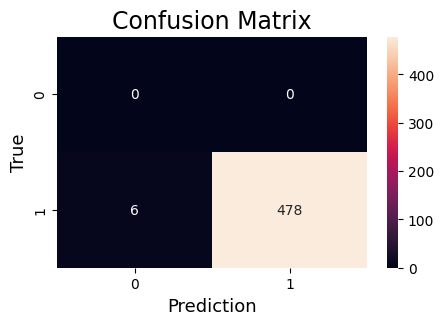

array([[  0,   0],
       [  6, 478]])

In [ ]:
confusion_matrix(y_true, y_pred)

In [ ]:
y_pred, y_true, y_prob, _ = get_predictions(pipe, neg_dataset, globals=glob_dict)
print(accuracy_score(y_pred, y_true))
# 0.9620535714285714

0.9732142857142857


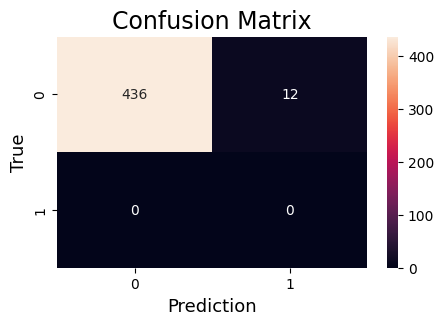

array([[436,  12],
       [  0,   0]])

In [ ]:
confusion_matrix(y_true, y_pred)

# show

0.987603305785124


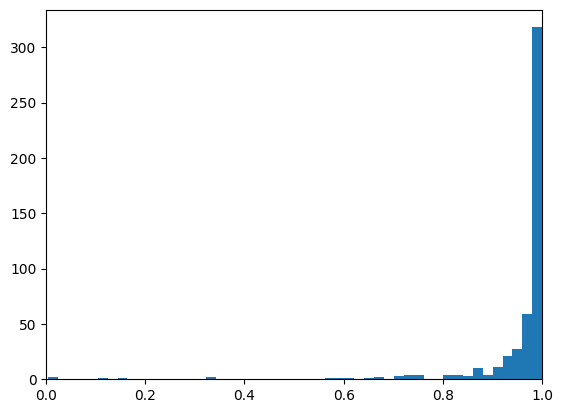

In [ ]:
y_pred, y_true, y_prob, _ = get_predictions(pipe, pos_dataset, globals=glob_dict)
print(accuracy_score(y_pred, y_true))

_ = plt.hist(y_prob.numpy(), bins = 50)
plt.xlim((0,1))
plt.show()
# 0.9896694214876033

0.9732142857142857


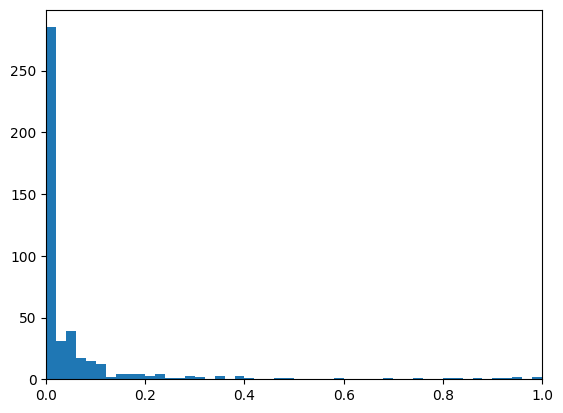

In [ ]:
y_pred, y_true, y_prob, _ = get_predictions(pipe, neg_dataset, globals=glob_dict)
print(accuracy_score(y_pred, y_true))

_ = plt.hist(y_prob.numpy(), bins = 50)
plt.xlim((0,1))
plt.show()
# 0.9754464285714286

prob > 0.8
count : 461 out of 484
pic idx : [0, 1, 2, 3, 4, 5, 6, 7]


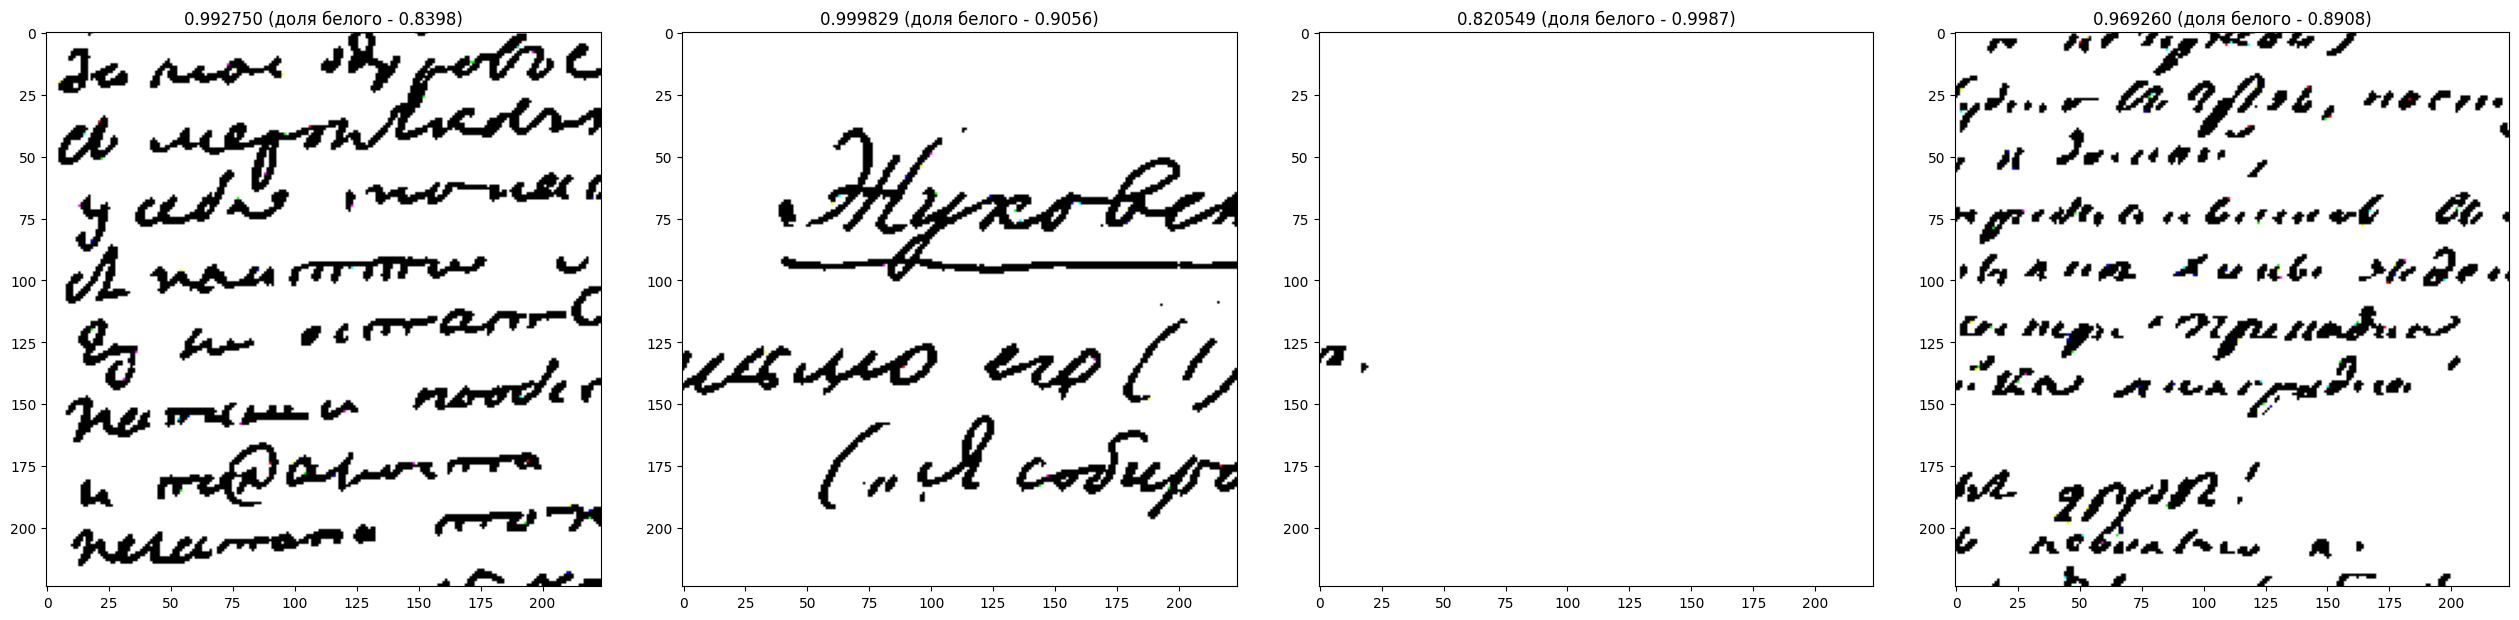

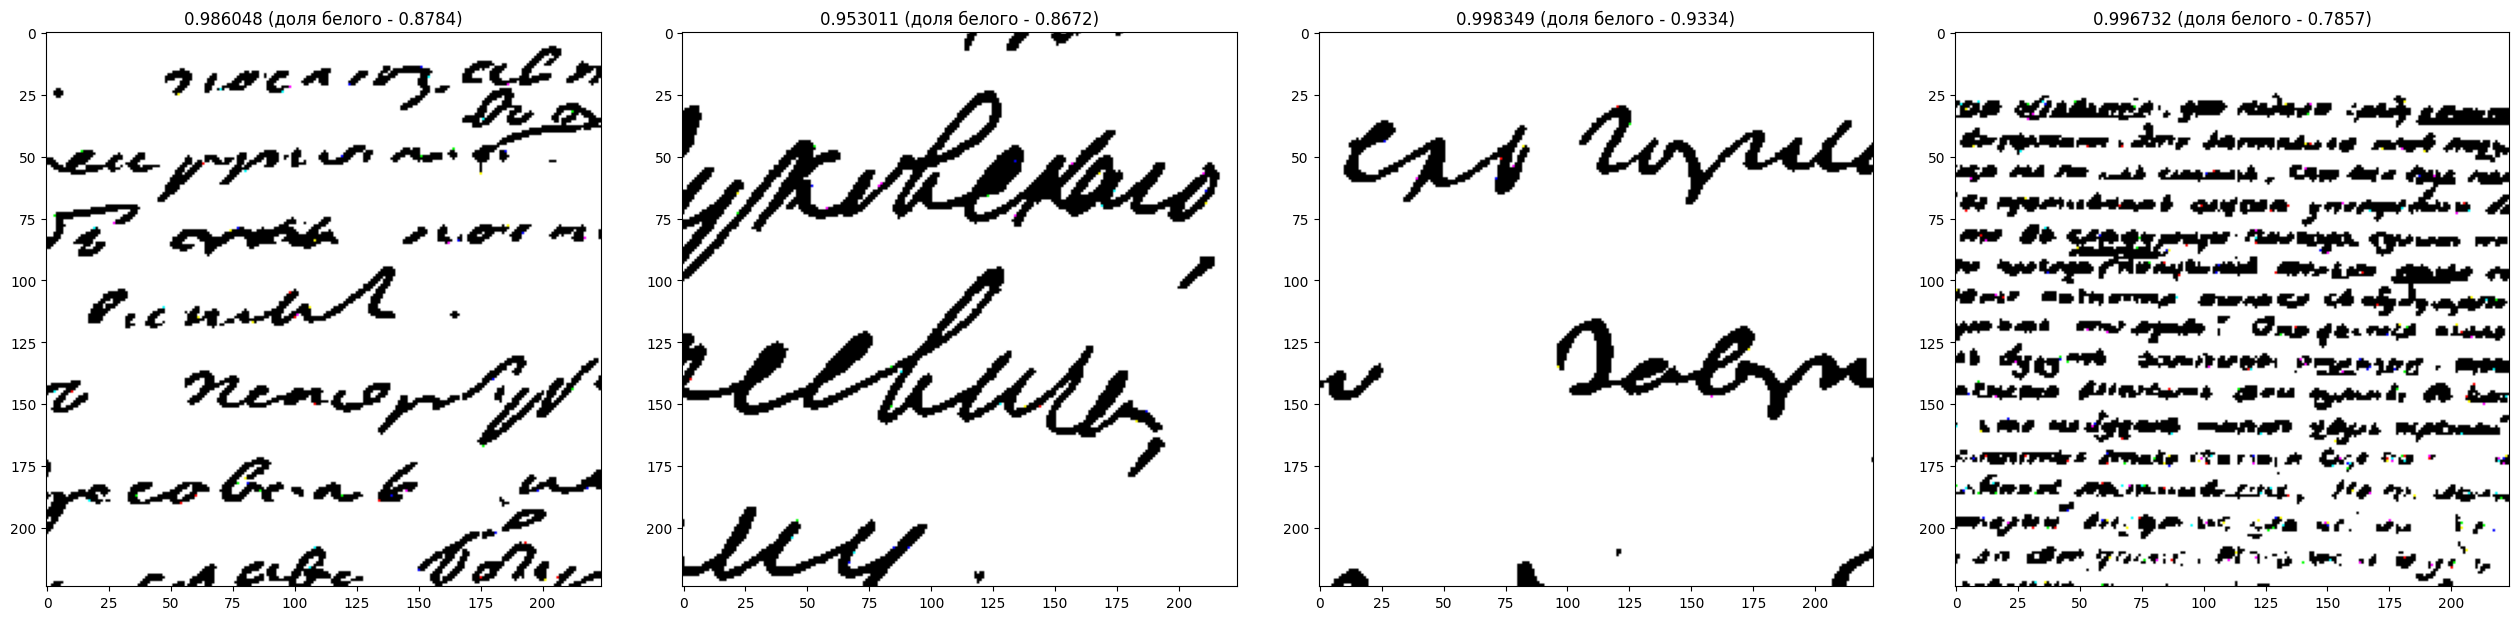

In [ ]:
y_pred, _, y_prob, X = show_result(pipe, pos_dataset, 0.8, greater=True, col = 8,
                                   globals=glob_dict)

prob < 0.6
count : 8 out of 484
pic idx : [86, 183, 209, 223, 254, 297, 407, 451]


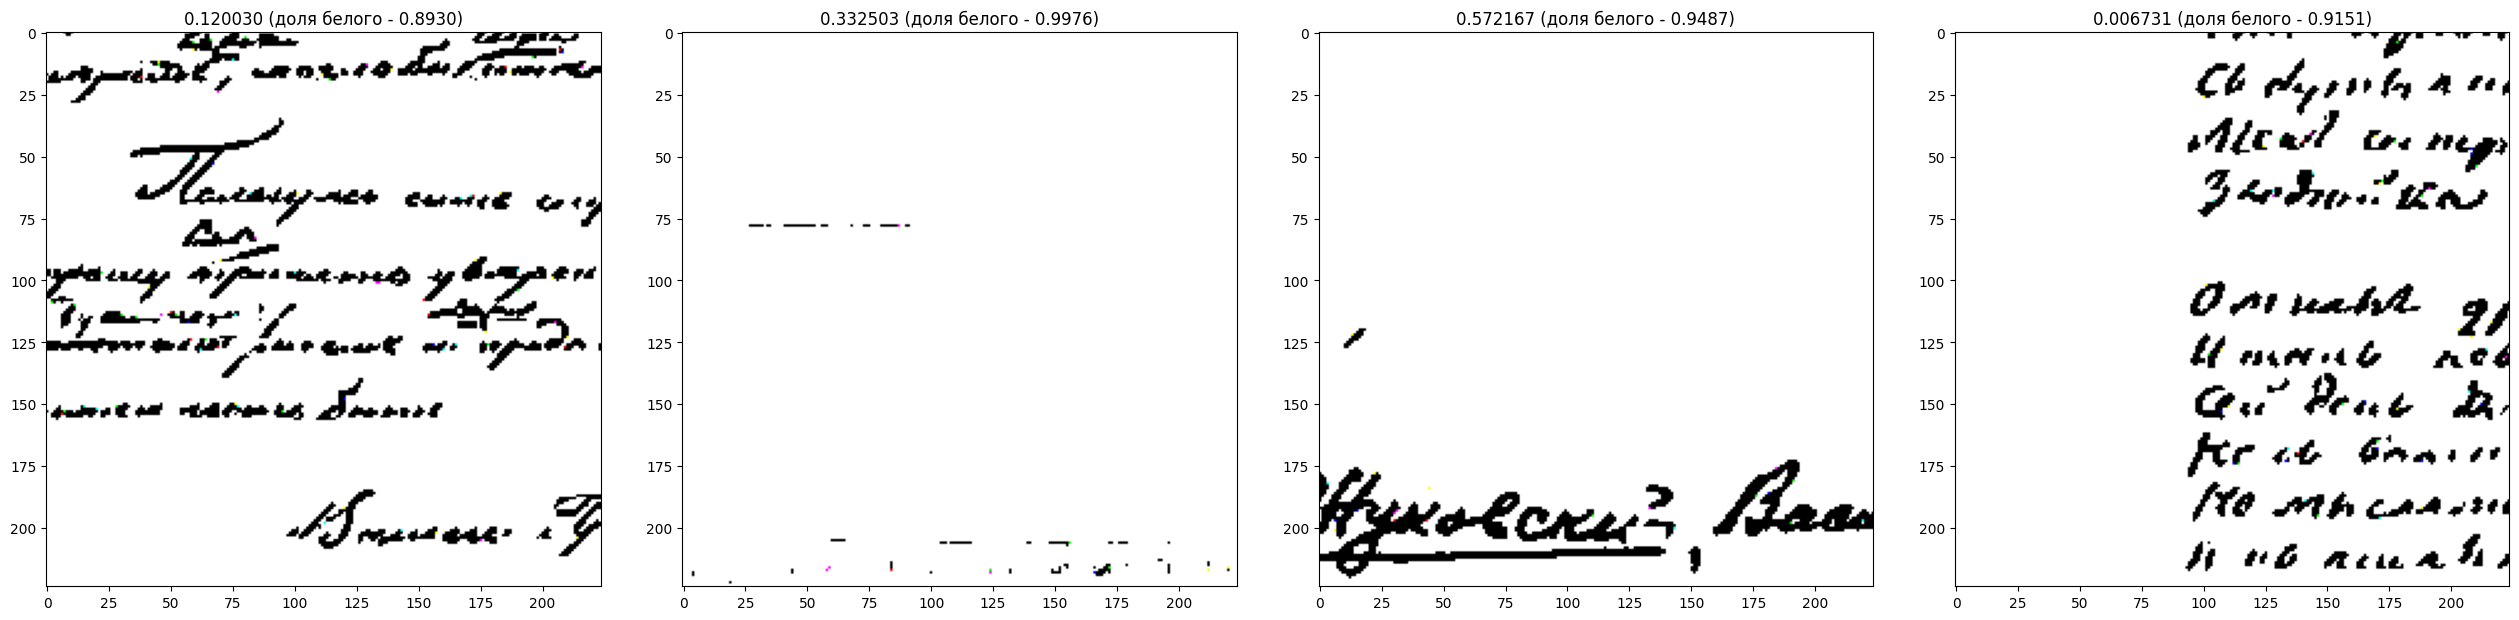

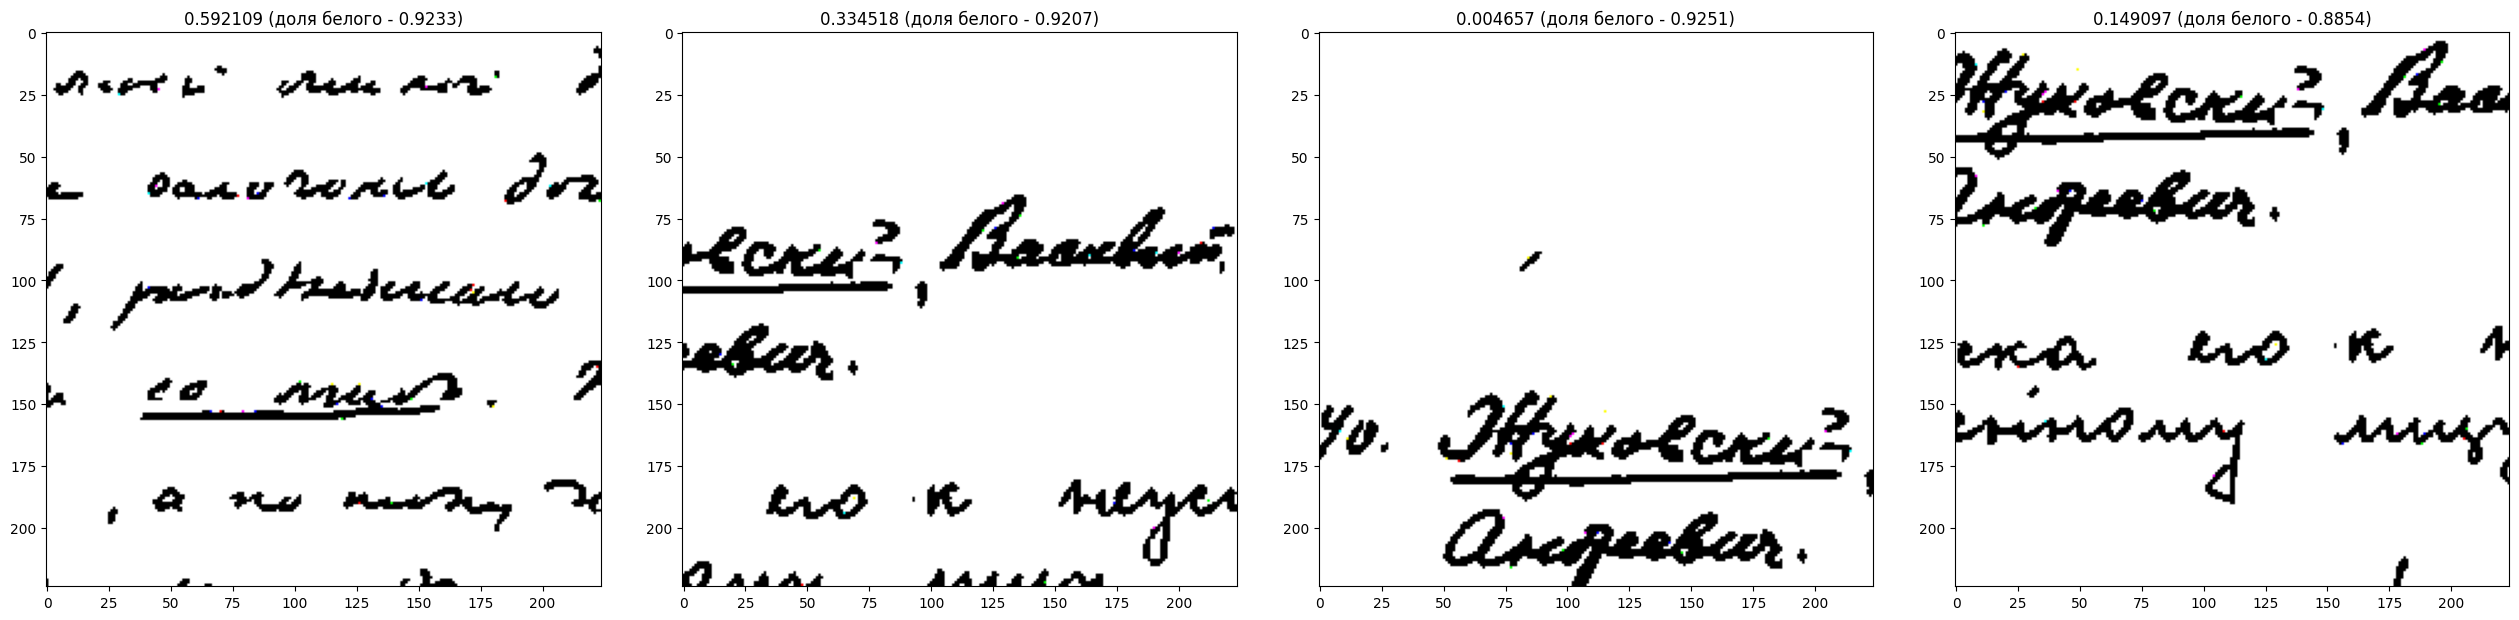

In [ ]:
y_pred, _, y_prob, X = show_result(pipe, pos_dataset, 0.6, greater = False, col = 8,
                                   globals=glob_dict)

In [ ]:
y_pred, _, y_prob, X = show_result(pipe, neg_dataset, 0.3, greater = False, col = 24,
                                   seed = 41, globals=glob_dict)

Output hidden; open in https://colab.research.google.com to view.

prob > 0.4
count : 15 out of 448
pic idx : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


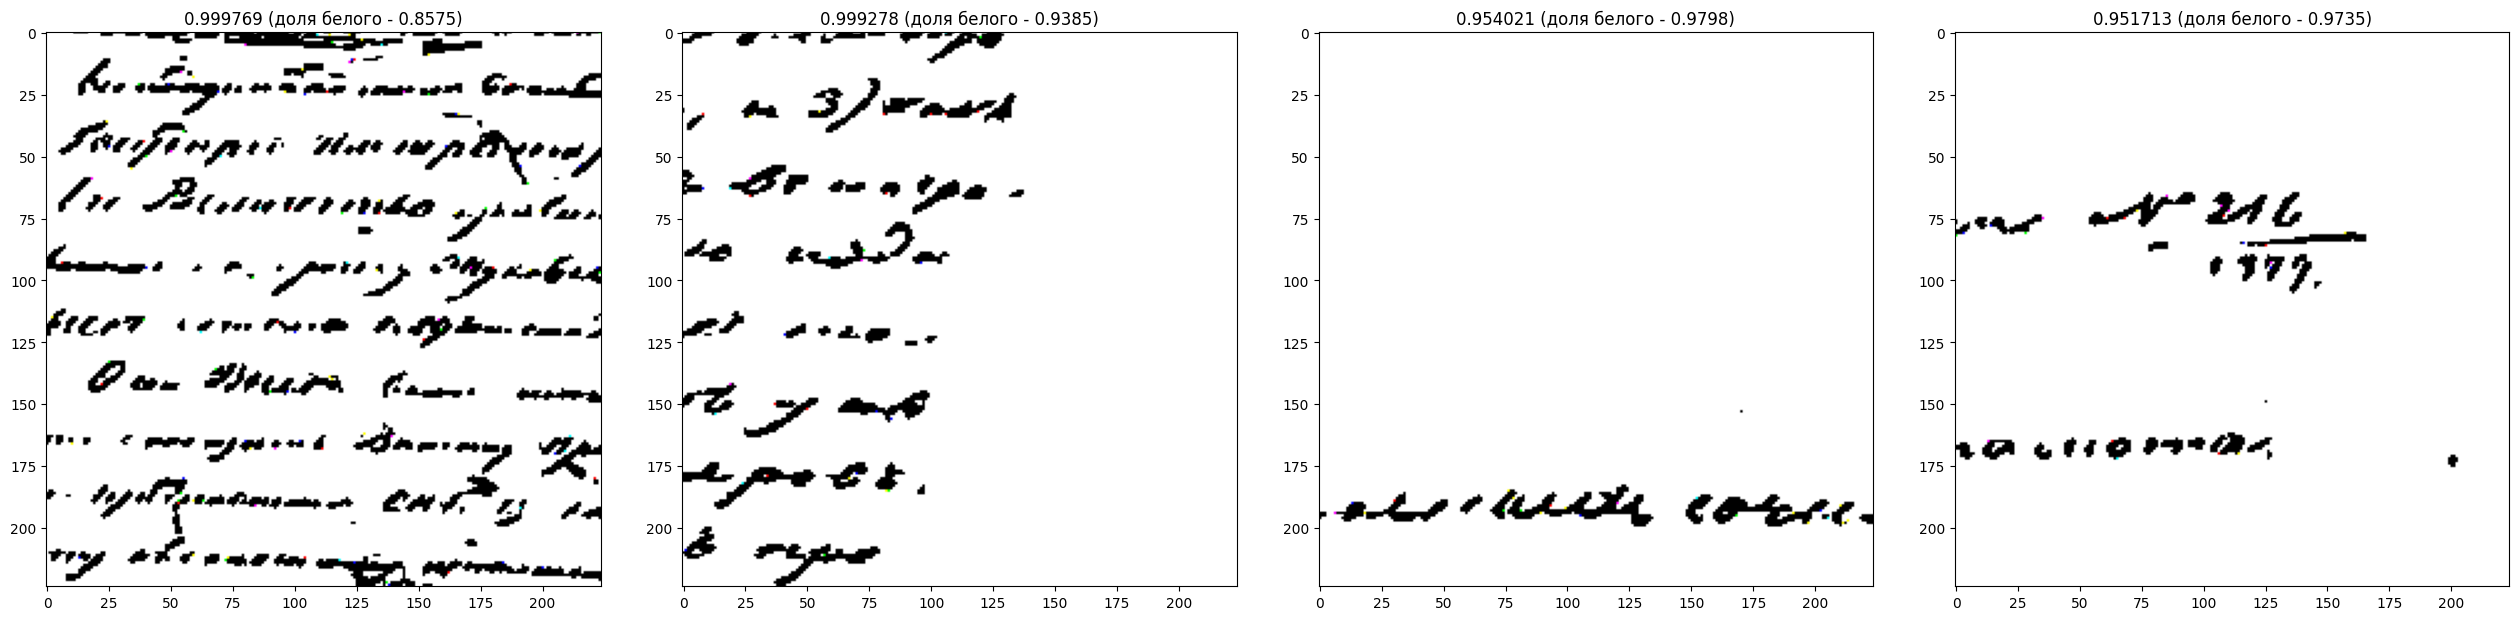

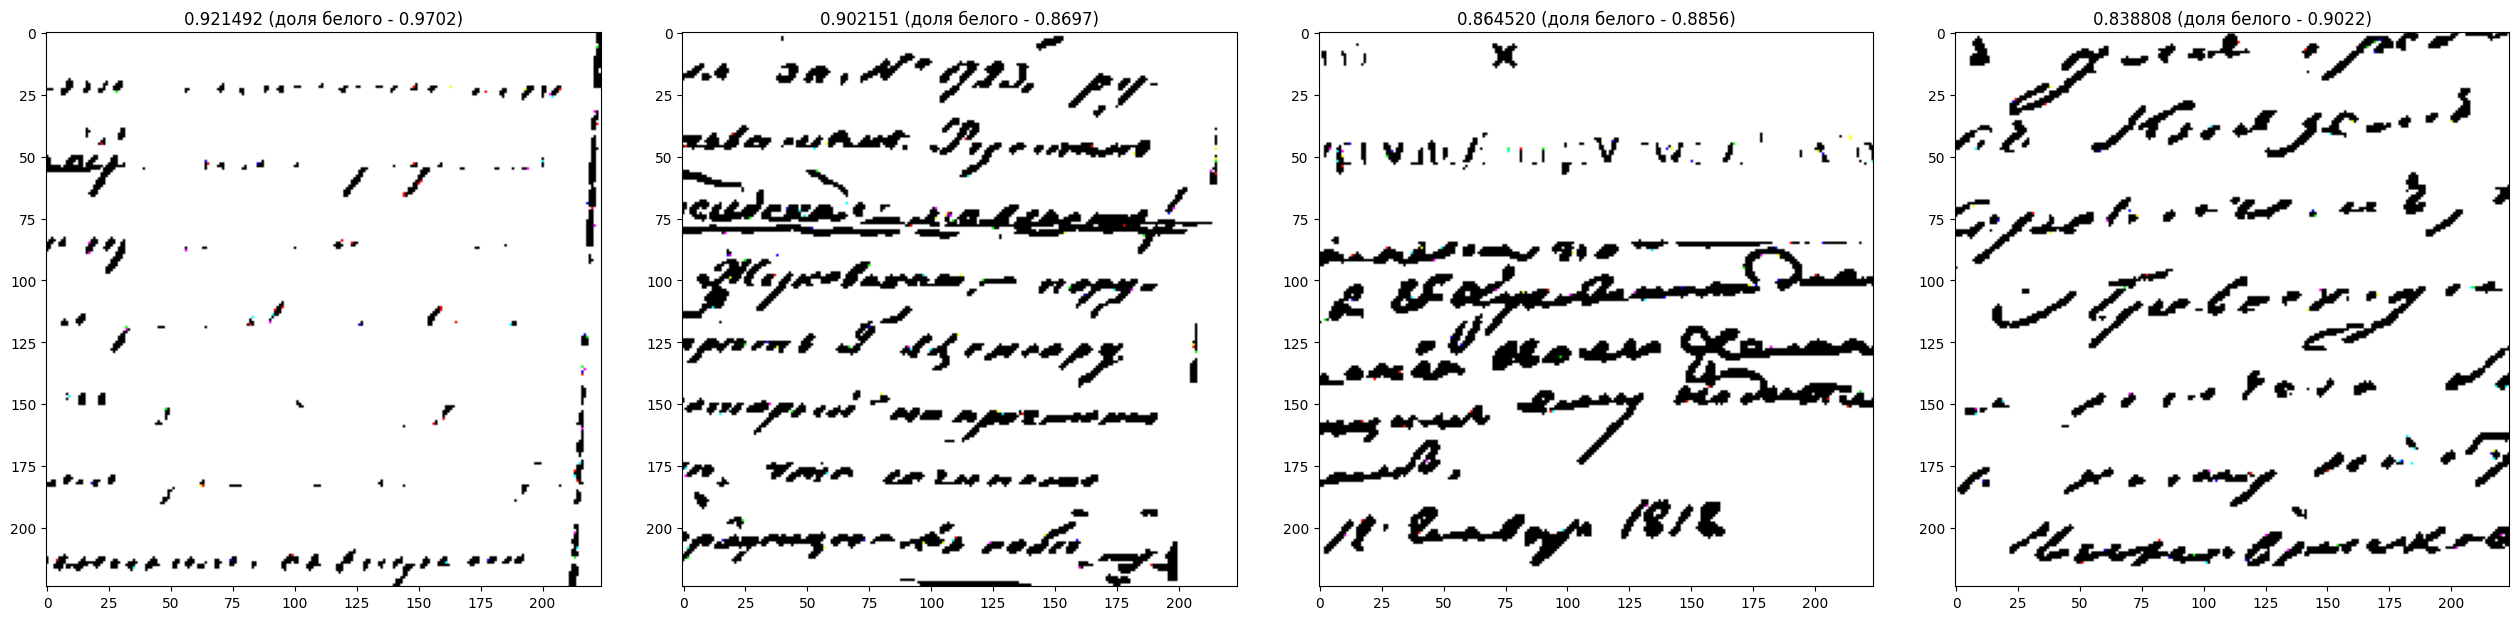

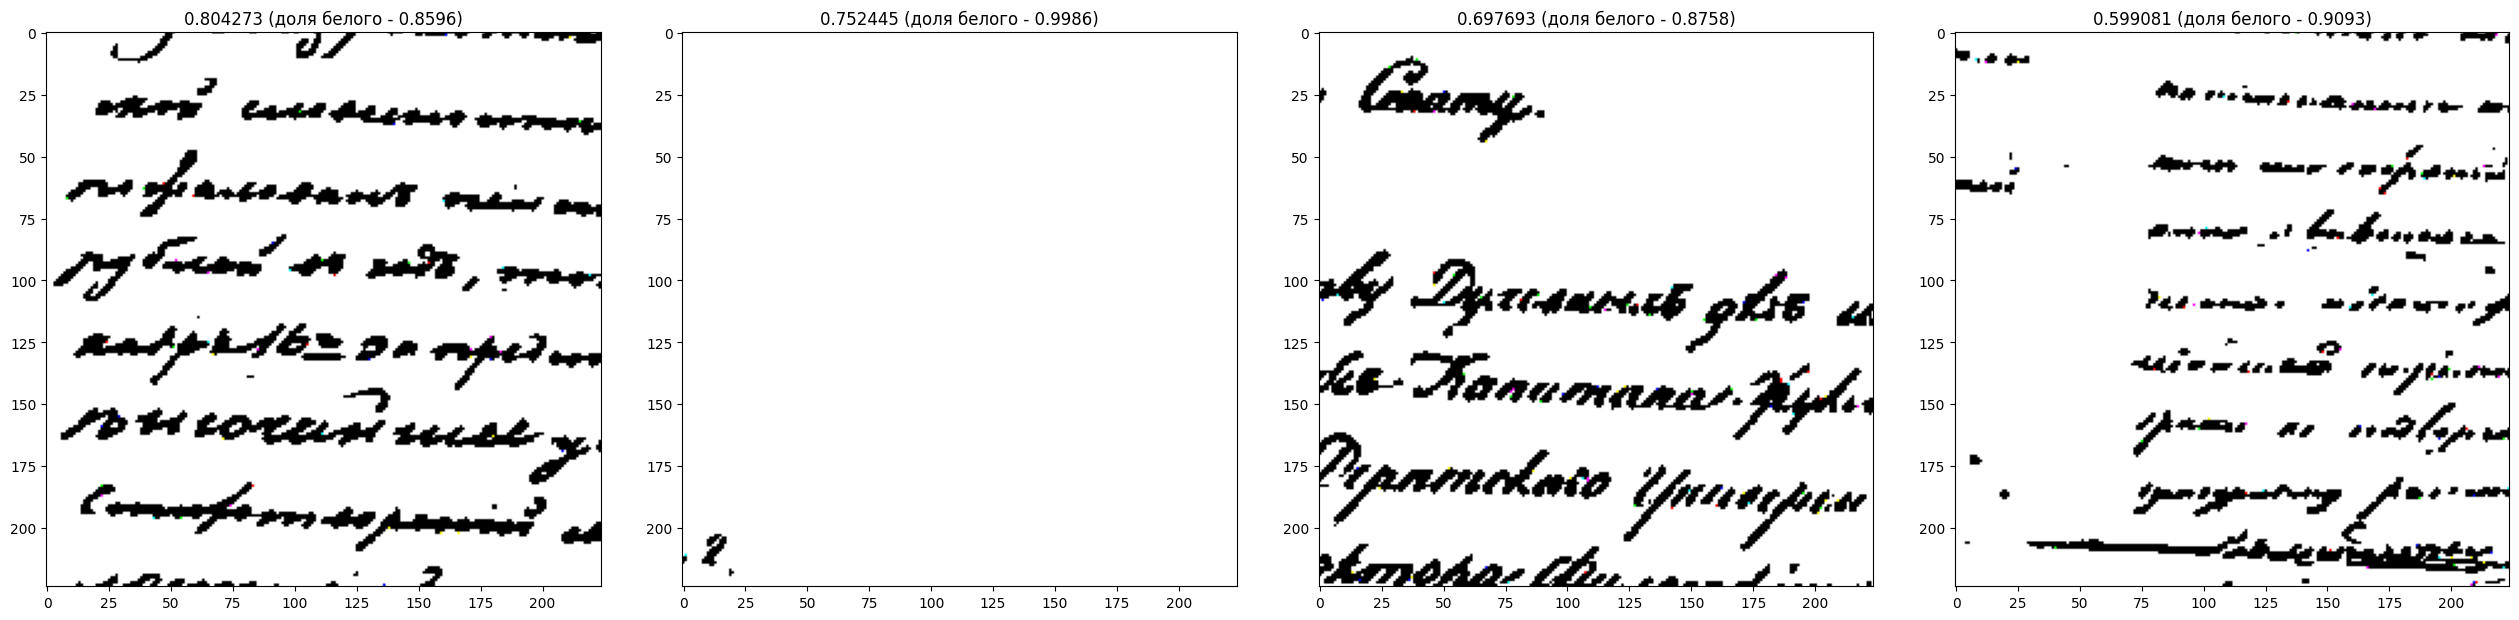

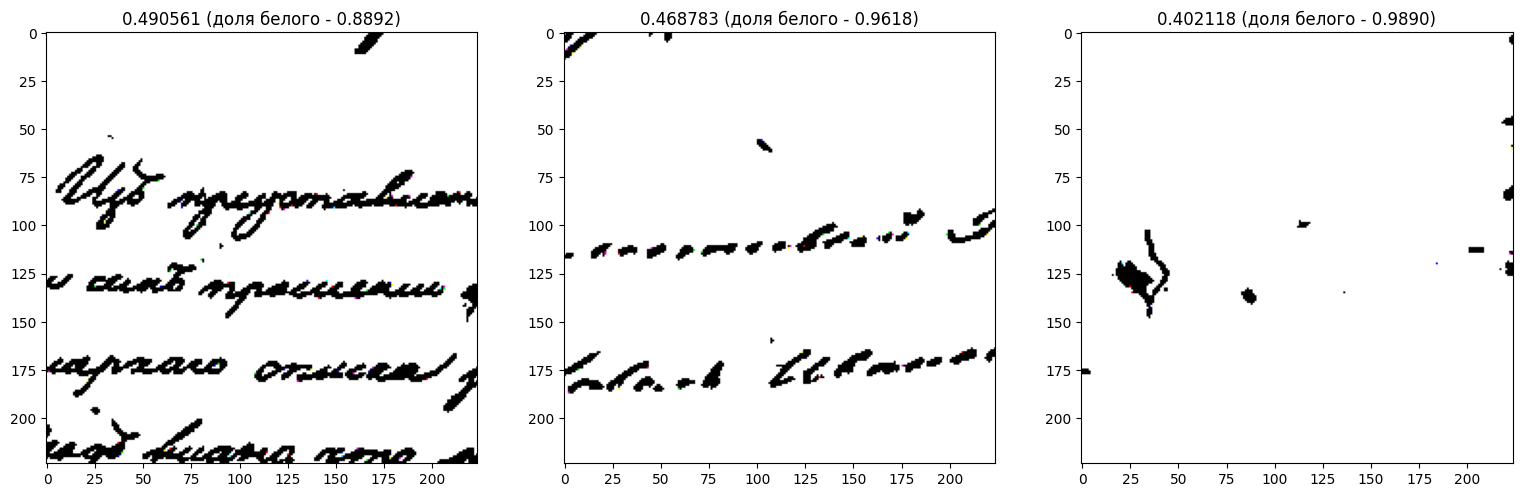

In [ ]:
y_pred, _, y_prob, X = show_result(pipe, neg_dataset, 0.4, greater = True, col = 24,
                                   sort = True, globals=glob_dict)

In [ ]:
# img = pos_dataset[0][0]
# img.shape

In [ ]:
# s = set()
# for i in range(300):
#     for j in range(300):
#         s |= {tuple(img[:, i, j].tolist())}

# s

In [ ]:
# x, num = np.unique(img.max(dim = 0)[0], return_counts = True)
# x, num

In [ ]:
# plt.figure(figsize=(20, 20))

# plt.imshow(np.transpose(img, (1, 2, 0)))

# on the entire dataset

In [ ]:
y_pred, _, y_prob, X = show_result(pipe, neg_dataset, 0, greater = True, col = 224,
                                   sort = True, globals=glob_dict)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
y_pred, _, y_prob, X = show_result(pipe, pos_dataset, 0, greater = True, col = 224,
                                   sort = True, globals=glob_dict)

Output hidden; open in https://colab.research.google.com to view.